In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import warnings
warnings.filterwarnings(action='ignore')

import folium
KC_coord = (47.4081,-121.9949)
Seattle_coord = (47.6062,-122.3321)
import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib inline
import seaborn as sns

plt.style.use('seaborn-notebook')
#from yellowbrick.regressor import ResidualsPlot

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OrdinalEncoder, OneHotEncoder

In [81]:
df = pd.read_csv('./data/kc_house_data.csv', index_col=0, parse_dates=['date']) 
# specify index_col=0 to avoid creating an "Unnamed: 0" column.
# specify parse date to avoid object dtype for dates
df

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,Average,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,NO,NONE,Average,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,NO,NONE,Average,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,NO,NONE,Very Good,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,NO,NONE,Average,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263000018,2014-05-21,360000.0,3,2.50,1530,1131,3.0,NO,NONE,Average,8 Good,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
6600060120,2015-02-23,400000.0,4,2.50,2310,5813,2.0,NO,NONE,Average,8 Good,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
1523300141,2014-06-23,402101.0,2,0.75,1020,1350,2.0,NO,NONE,Average,7 Average,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007


In [3]:
len(df)

21597

In [4]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [5]:
df.corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
price,1.000000,0.308787,0.525906,0.701917,0.089876,0.256804,0.605368,0.053953,0.129599,-0.053402,0.306692,0.022036,0.585241,0.082845
bedrooms,0.308787,1.000000,0.514508,0.578212,0.032471,0.177944,0.479386,0.155670,0.018495,-0.154092,-0.009951,0.132054,0.393406,0.030690
bathrooms,0.525906,0.514508,1.000000,0.755758,0.088373,0.502582,0.686668,0.507173,0.051050,-0.204786,0.024280,0.224903,0.569884,0.088303
sqft_living,0.701917,0.578212,0.755758,1.000000,0.173453,0.353953,0.876448,0.318152,0.055660,-0.199802,0.052155,0.241214,0.756402,0.184342
sqft_lot,0.089876,0.032471,0.088373,0.173453,1.000000,-0.004814,0.184139,0.052946,0.004513,-0.129586,-0.085514,0.230227,0.144763,0.718204
floors,0.256804,0.177944,0.502582,0.353953,-0.004814,1.000000,0.523989,0.489193,0.003535,-0.059541,0.049239,0.125943,0.280102,-0.010722
sqft_above,0.605368,0.479386,0.686668,0.876448,0.184139,0.523989,1.000000,0.424037,0.022137,-0.261570,-0.001199,0.344842,0.731767,0.195077
yr_built,0.053953,0.155670,0.507173,0.318152,0.052946,0.489193,0.424037,1.000000,-0.225209,-0.347210,-0.148370,0.409993,0.326377,0.070777
yr_renovated,0.129599,0.018495,0.051050,0.055660,0.004513,0.003535,0.022137,-0.225209,1.000000,0.069846,0.032145,-0.072156,-0.000247,0.003852
zipcode,-0.053402,-0.154092,-0.204786,-0.199802,-0.129586,-0.059541,-0.261570,-0.347210,0.069846,1.000000,0.266742,-0.564259,-0.279299,-0.147294


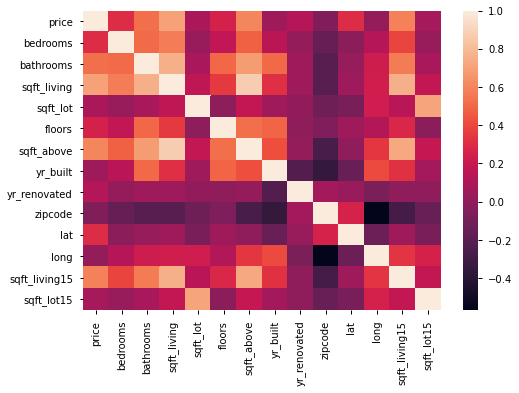

In [6]:
sns.heatmap(df.corr());

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 7129300520 to 1523300157
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           21597 non-null  datetime64[ns]
 1   price          21597 non-null  float64       
 2   bedrooms       21597 non-null  int64         
 3   bathrooms      21597 non-null  float64       
 4   sqft_living    21597 non-null  int64         
 5   sqft_lot       21597 non-null  int64         
 6   floors         21597 non-null  float64       
 7   waterfront     19221 non-null  object        
 8   view           21534 non-null  object        
 9   condition      21597 non-null  object        
 10  grade          21597 non-null  object        
 11  sqft_above     21597 non-null  int64         
 12  sqft_basement  21597 non-null  object        
 13  yr_built       21597 non-null  int64         
 14  yr_renovated   17755 non-null  float64       
 15  zipco

In [8]:
df.isna().sum()

date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [9]:
waterfront_count = df['waterfront'].value_counts()
waterfront_count

NO     19075
YES      146
Name: waterfront, dtype: int64

In [10]:
waterfront_proportions = df['waterfront'].value_counts()[1] / df['waterfront'].value_counts()[0]
waterfront_proportions

0.007653997378768021

In [11]:
watefront_null_proportion = df['waterfront'].isna().sum() * waterfront_proportions
watefront_null_proportion

18.185897771952817

In [12]:
waterfront_yes = df.loc[ df['waterfront'] == 'YES' ]

waterfront_avg_yes_price = np.mean( waterfront_yes['price'] )
waterfront_med_yes_price = np.median( waterfront_yes['price'] )

waterfront_null = df[df['waterfront'].isna()]
waterfront_null.loc[~waterfront_null.index.duplicated(), :]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,Average,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1736800520,2015-04-03,662500.0,3,2.50,3560,9796,1.0,NaN,NONE,Average,8 Good,1860,1700.0,1965,0.0,98007,47.6007,-122.145,2210,8925
8091400200,2014-05-16,252700.0,2,1.50,1070,9643,1.0,NaN,NONE,Average,7 Average,1070,0.0,1985,NaN,98030,47.3533,-122.166,1220,8386
5547700270,2014-07-15,625000.0,4,2.50,2570,5520,2.0,NaN,NONE,Average,9 Better,2570,0.0,2000,NaN,98074,47.6145,-122.027,2470,5669
9822700295,2014-05-12,885000.0,4,2.50,2830,5000,2.0,NaN,NONE,Average,9 Better,2830,0.0,1995,0.0,98105,47.6597,-122.290,1950,5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5087900040,2014-10-17,350000.0,4,2.75,2500,5995,2.0,NaN,NONE,Average,8 Good,2500,0.0,2008,0.0,98042,47.3749,-122.107,2530,5988
8956200760,2014-10-13,541800.0,4,2.50,3118,7866,2.0,NaN,AVERAGE,Average,9 Better,3118,0.0,2014,0.0,98001,47.2931,-122.264,2673,6500
844000965,2014-06-26,224000.0,3,1.75,1500,11968,1.0,NaN,NONE,Average,6 Low Average,1500,0.0,2014,0.0,98010,47.3095,-122.002,1320,11303


In [13]:
waterfront_null_avg_filter = waterfront_null.loc[ waterfront_null['price'] >= waterfront_avg_yes_price ]
waterfront_null_med_filter = waterfront_null.loc[ waterfront_null['price'] >= waterfront_med_yes_price ]
waterfront_med = np.median(waterfront_null_med_filter['price'])


waterfront_null_avg_count = len(waterfront_null_avg_filter)  
waterfront_null_med_count = len(waterfront_null_med_filter) 

waterfront_convert = waterfront_null_med_count * waterfront_proportions

print(f"""mean: {np.round(waterfront_avg_yes_price, 2)}, count: {waterfront_null_avg_count} 

median: {waterfront_med_yes_price}, count: {waterfront_null_med_count}

waterfront_convert: {waterfront_convert}

median waterfront homes >= waterfront_med_yes_price: {waterfront_med}

{waterfront_null_med_filter}""")

mean: 1717214.73, count: 31 

median: 1510000.0, count: 53

waterfront_convert: 0.40566186107470514

median waterfront homes >= waterfront_med_yes_price: 1820000.0

                 date      price  bedrooms  bathrooms  sqft_living  sqft_lot  \
id                                                                             
46100204   2015-02-21  1510000.0         5       3.00         3300     33474   
3225079035 2014-06-18  1600000.0         6       5.00         6050    230652   
5486800070 2014-06-20  1950000.0         7       3.50         4640     15235   
8081500060 2014-10-01  1930000.0         4       3.25         4280     20296   
1118000465 2015-03-12  1810000.0         3       3.50         3780      8295   
7856400240 2015-02-11  1650000.0         4       3.00         3900      9750   
5452301785 2015-02-18  2300000.0         4       4.25         4070     13860   
251620110  2014-07-02  2290000.0         4       2.50         4080     18362   
1959701745 2014-11-07  1680000.0   

In [14]:
view_count = df['view'].value_counts()
view_count

NONE         19422
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
Name: view, dtype: int64

In [15]:
condition_count = df['condition'].value_counts()
condition_count

Average      14020
Good          5677
Very Good     1701
Fair           170
Poor            29
Name: condition, dtype: int64

In [16]:
bedroom_count = df['bedrooms'].value_counts()
bedroom_count

3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

# Data Preparation

In [17]:
#drop the 33 bedroom outlier 
df = df[df['bedrooms'] != 33]

In [18]:
df['bedrooms_bin']=pd.cut(df['bedrooms'], bins = [0,1,2,3,4,5,6,99], labels=['1 bed','2 bed','3 bed','4 bed','5 bed','6 bed','7+ bed'])
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,bedrooms_bin
id,,,,,,,,,,,,,,,,,,,,,
7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,Average,...,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,3 bed
6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,NO,NONE,Average,...,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,3 bed
5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,NO,NONE,Average,...,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062,2 bed
2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,NO,NONE,Very Good,...,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000,4 bed
1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,NO,NONE,Average,...,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,3 bed


In [19]:
#drop the 33 bedroom outlier 
df.drop(['date', 'yr_renovated', 'sqft_basement'], axis=1, inplace=True)
df.head()


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,bedrooms_bin
id,,,,,,,,,,,,,,,,,,
7129300520,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,Average,7 Average,1180,1955,98178,47.5112,-122.257,1340,5650,3 bed
6414100192,538000.0,3,2.25,2570,7242,2.0,NO,NONE,Average,7 Average,2170,1951,98125,47.7210,-122.319,1690,7639,3 bed
5631500400,180000.0,2,1.00,770,10000,1.0,NO,NONE,Average,6 Low Average,770,1933,98028,47.7379,-122.233,2720,8062,2 bed
2487200875,604000.0,4,3.00,1960,5000,1.0,NO,NONE,Very Good,7 Average,1050,1965,98136,47.5208,-122.393,1360,5000,4 bed
1954400510,510000.0,3,2.00,1680,8080,1.0,NO,NONE,Average,8 Good,1680,1987,98074,47.6168,-122.045,1800,7503,3 bed


# Taking Out Outliers

### Price Outliers

In [20]:
# calculate 25, 75, iqr, whiskers for 'price'
price_q25, price_q75 = np.percentile(df['price'], [25, 75])
price_iqr = price_q75 - price_q25
price_min = price_q25 - (1.5 * price_iqr)
price_max = price_q75 + (1.5 * price_iqr)

print(f"""price_min: {price_min} 
price_max: {price_max}""")

price_min: -162500.0 
price_max: 1129500.0


In [21]:
# set df to include everything within the whiskers except the outliers
df = df[df['price'] >= price_min]
df = df[df['price'] <= price_max]

### Sqft Lot Outliers

In [22]:
# calculate 25, 75, iqr, whiskers for 'sqft_lot'
sqft_lot_q25, sqft_lot_q75 = np.percentile(df['sqft_lot'], [25, 75])
sqft_lot_iqr = sqft_lot_q75 - sqft_lot_q25
sqft_lot_min = sqft_lot_q25 - (1.5 * sqft_lot_iqr)
sqft_lot_max = sqft_lot_q75 + (1.5 * sqft_lot_iqr)


print(f"""sqft_lot_min: {sqft_lot_min} 
sqft_lot_max: {sqft_lot_max}""")

sqft_lot_min: -2975.125 
sqft_lot_max: 18291.875


In [23]:
# set df to include everything within the whiskers except the outliers
df = df[df['sqft_lot'] >= sqft_lot_min]
df = df[df['sqft_lot'] <= sqft_lot_max]

### Grade Outliers

In [24]:
# check value counts of grades
grade_count = print(df['grade'].value_counts())

7 Average        8371
8 Good           5297
6 Low Average    1872
9 Better         1866
10 Very Good      513
5 Fair            198
11 Excellent       75
4 Low              20
12 Luxury           1
3 Poor              1
Name: grade, dtype: int64


In [25]:
df = df[df['grade'] != '3 Poor']
df = df[df['grade'] != '12 Luxury']

ohe executes 2 transformations, test and train. data for any given input variable: First, we use OneHotEncoder to split up our categorical variables. Second, we run a linear regression on encoded values using .fit(). Then, it takes in a training df ('df'), a test df ('df2') and a column name. Next, it returns the training df and the test df concatenated with newly encoded columns. Lastly, we return a list of these newly encoded column names. 

In [26]:
def ohe(df, df2, column):
    for col in column:
        train = df[[col]]
        ohe = OneHotEncoder(drop='first', sparse=False, handle_unknown="error")
        ohe.fit(train)
        encoded_train = ohe.transform(train)
        col_labels = [f"{col}_{f}" for f in ohe.get_feature_names()]
        encoded_train = pd.DataFrame(encoded_train, columns=col_labels, index=df.index)
        df = pd.concat([df, encoded_train], axis=1)
        
        test = df2[[col]]
        encoded_test = ohe.transform(test)
        col_labels = [f"{col}_{f}" for f in ohe.get_feature_names()]
        encoded_test = pd.DataFrame(encoded_test, columns=col_labels, index=df2.index)
        df2 = pd.concat([df2, encoded_test], axis=1)
        
    return df, df2, encoded_train.columns.tolist()

We run a Standard Scaler to scale all the values in the test data and training data so that our models results are in comparable units. Then, we score the scaled data to get the R2 to assess the strength of our model.

In [27]:
def scale_score(x, y, x2, y2):
    scaler = StandardScaler()
    scaler.fit(x)
    X_train_scaled = scaler.transform(x)
    X_test_scaled = scaler.transform(x2)
    
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    
    train_pred = model.predict(X_train_scaled)
    test_pred = model.predict(X_test_scaled)
    
    print(f"""training score: {r2_score(y_train, train_pred)}
    test score: {r2_score(y_test, test_pred)}""")
    
    return X_train_scaled, X_test_scaled, train_pred, test_pred

Uses price and predictions to calculate Mean Absolute Error (MAE), Mean Squared Error (MSE) and Root Mean Squared Error (RSME) for the training and testing data sets. We will compare these values to evaluate model performance.

In [28]:
def get_train_test_metrics(y_train,train_preds,
               y_test,test_preds
              ):
    """
    Prints different training and testing metrics, namely R2, MAE, MSE, RMSE
    """
    print("\nTraining Metrics:")
    print(f"R2: {r2_score(y_train, train_preds):.3f}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_train, train_preds):.3f}")
    print(f"Mean Squared Error: {mean_squared_error(y_train, train_preds):.3f}")
    print(f"Root Mean Squared Error: {mean_squared_error(y_train, train_preds, squared=False):.3f}")
    
    print("\nTesting Metrics:")
    print(f"R2: {r2_score(y_test, test_preds):.3f}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_test, test_preds):.3f}")
    print(f"Mean Squared Error: {mean_squared_error(y_test, test_preds):.3f}")
    print(f"Root Mean Squared Error: {mean_squared_error(y_test, test_preds, squared=False):.3f}")

In [29]:
y = df['price']
X = df.drop('price', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.25)

### Condition

In [30]:
X_train, X_test, encoded_condition = ohe(X_train, X_test, ['condition'])

In [31]:
X_train['condition'] = X_train['condition'].map({'Very Good': 5, 'Good': 4, 'Average': 3, 'Fair': 2, 'Poor': 1})

In [32]:
X_test['condition'] = X_test['condition'].map({'Very Good': 5, 'Good': 4, 'Average': 3, 'Fair': 2, 'Poor': 1})

### View

In [33]:
X_train['view'].isna().sum()

45

In [34]:
X_train['view'].fillna('NONE', inplace=True)
X_test['view'].fillna('NONE', inplace=True)

In [35]:


X_train, X_test, encoded_view = ohe(X_train, X_test, ['view'])

In [36]:
X_train['view'] = X_train['view'].map({'EXCELLENT': 5, 'GOOD': 4, 'AVERAGE': 3, 'FAIR': 2, 'NONE': 1})

In [37]:
X_test['view'] = X_test['view'].map({'EXCELLENT': 5, 'GOOD': 4, 'AVERAGE': 3, 'FAIR': 2, 'NONE': 1})

### Waterfront

In [38]:
X_train['waterfront'].fillna('NO', inplace=True)
X_test['waterfront'].fillna('NO', inplace=True)

In [39]:
waterfront_train = X_train[['waterfront']]

encoder_waterfront = OrdinalEncoder()
encoder_waterfront.fit(waterfront_train)
encoder_waterfront.categories_[0]
waterfront_encoded_train = encoder_waterfront.transform(waterfront_train)
waterfront_encoded_train = waterfront_encoded_train.flatten()

X_train['waterfront'] = waterfront_encoded_train

In [40]:
waterfront_test = X_test[['waterfront']]

encoder_waterfront = OrdinalEncoder()
encoder_waterfront.fit(waterfront_test)
encoder_waterfront.categories_[0]
waterfront_encoded_test = encoder_waterfront.transform(waterfront_test)
waterfront_encoded_test = waterfront_encoded_train.flatten()

X_train['waterfront'] = waterfront_encoded_test

### Bedroom Bins

In [41]:
X_train, X_test, encoded_bedrooms_bins = ohe(X_train, X_test, ['bedrooms_bin'])

### Grade

In [42]:
X_train, X_test, encoded_grade = ohe(X_train, X_test, ['grade'])

### Zipcode

In [43]:
X_train, X_test, encoded_zipcode = ohe(X_train, X_test, ['zipcode'])

In [44]:
dummy = DummyRegressor()
dummy.fit(X_train, y_train)
dummy.score(X_train, y_train)

0.0

In [45]:
cols = ['sqft_living']
y = y_train
x = X_train.filter(cols, axis=1)
y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [46]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.35205094281398364
    test score: 0.37900938149625407


In [47]:
y_sqft_liv = df['price']
X_sqft_liv = df['sqft_living']

model = sm.OLS(y_sqft_liv, sm.add_constant(X_sqft_liv)).fit()
model_summary = model.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                 1.019e+04
Date:                Tue, 02 Aug 2022   Prob (F-statistic):               0.00
Time:                        22:41:57   Log-Likelihood:            -2.4446e+05
No. Observations:               18212   AIC:                         4.889e+05
Df Residuals:                   18210   BIC:                         4.889e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.454e+05   3405.658     42.699      0.000    1.39e+05    1.52e+05
sqft_living   168.2449      1.667    100.941      0.000     164.978     171.512
==============================================================================
Omnibus:                      823.794   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              938.325
Skew:                           0.549   Prob(JB):                    1.76e-204
Kurtosis:                       3.171   Cond. No.                     5.75e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.75e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [48]:
type(X)

pandas.core.frame.DataFrame

In [49]:
df.corr()['price'].abs().sort_values(ascending=False)

price            1.000000
sqft_living      0.598983
sqft_living15    0.536502
sqft_above       0.492556
lat              0.450100
bathrooms        0.429260
bedrooms         0.292722
floors           0.262999
long             0.034681
sqft_lot15       0.024641
yr_built         0.024433
sqft_lot         0.005248
zipcode          0.003252
Name: price, dtype: float64

In [50]:
df['price']

id
7129300520    221900.0
6414100192    538000.0
5631500400    180000.0
2487200875    604000.0
1954400510    510000.0
                ...   
263000018     360000.0
6600060120    400000.0
1523300141    402101.0
291310100     400000.0
1523300157    325000.0
Name: price, Length: 18212, dtype: float64

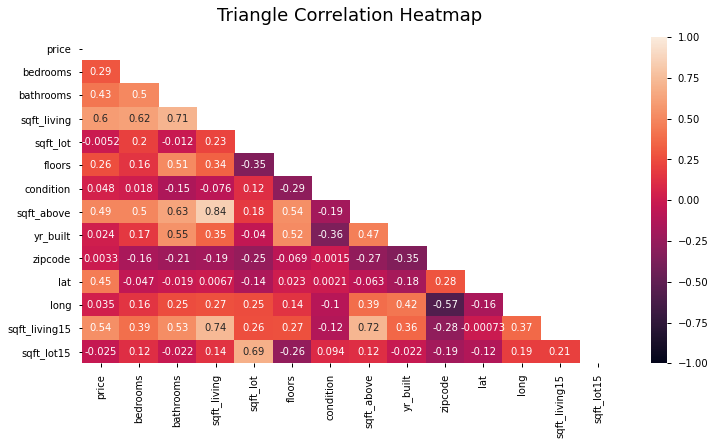

In [51]:
#Changing 'condition' object to ints and creating a heatmap for reference
ndf = df.copy()
ndf['condition'] = ndf['condition'].map({'Very Good': 5, 'Good': 4, 'Average': 3, 'Fair': 2, 'Poor': 1})

plt.figure(figsize=(12, 6))
mask = np.triu(np.ones_like(ndf.corr(), dtype=bool))
heatmap = sns.heatmap(ndf.corr(), mask=mask, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

In [52]:
relcols = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'floors', 'sqft_above', 'sqft_living15']

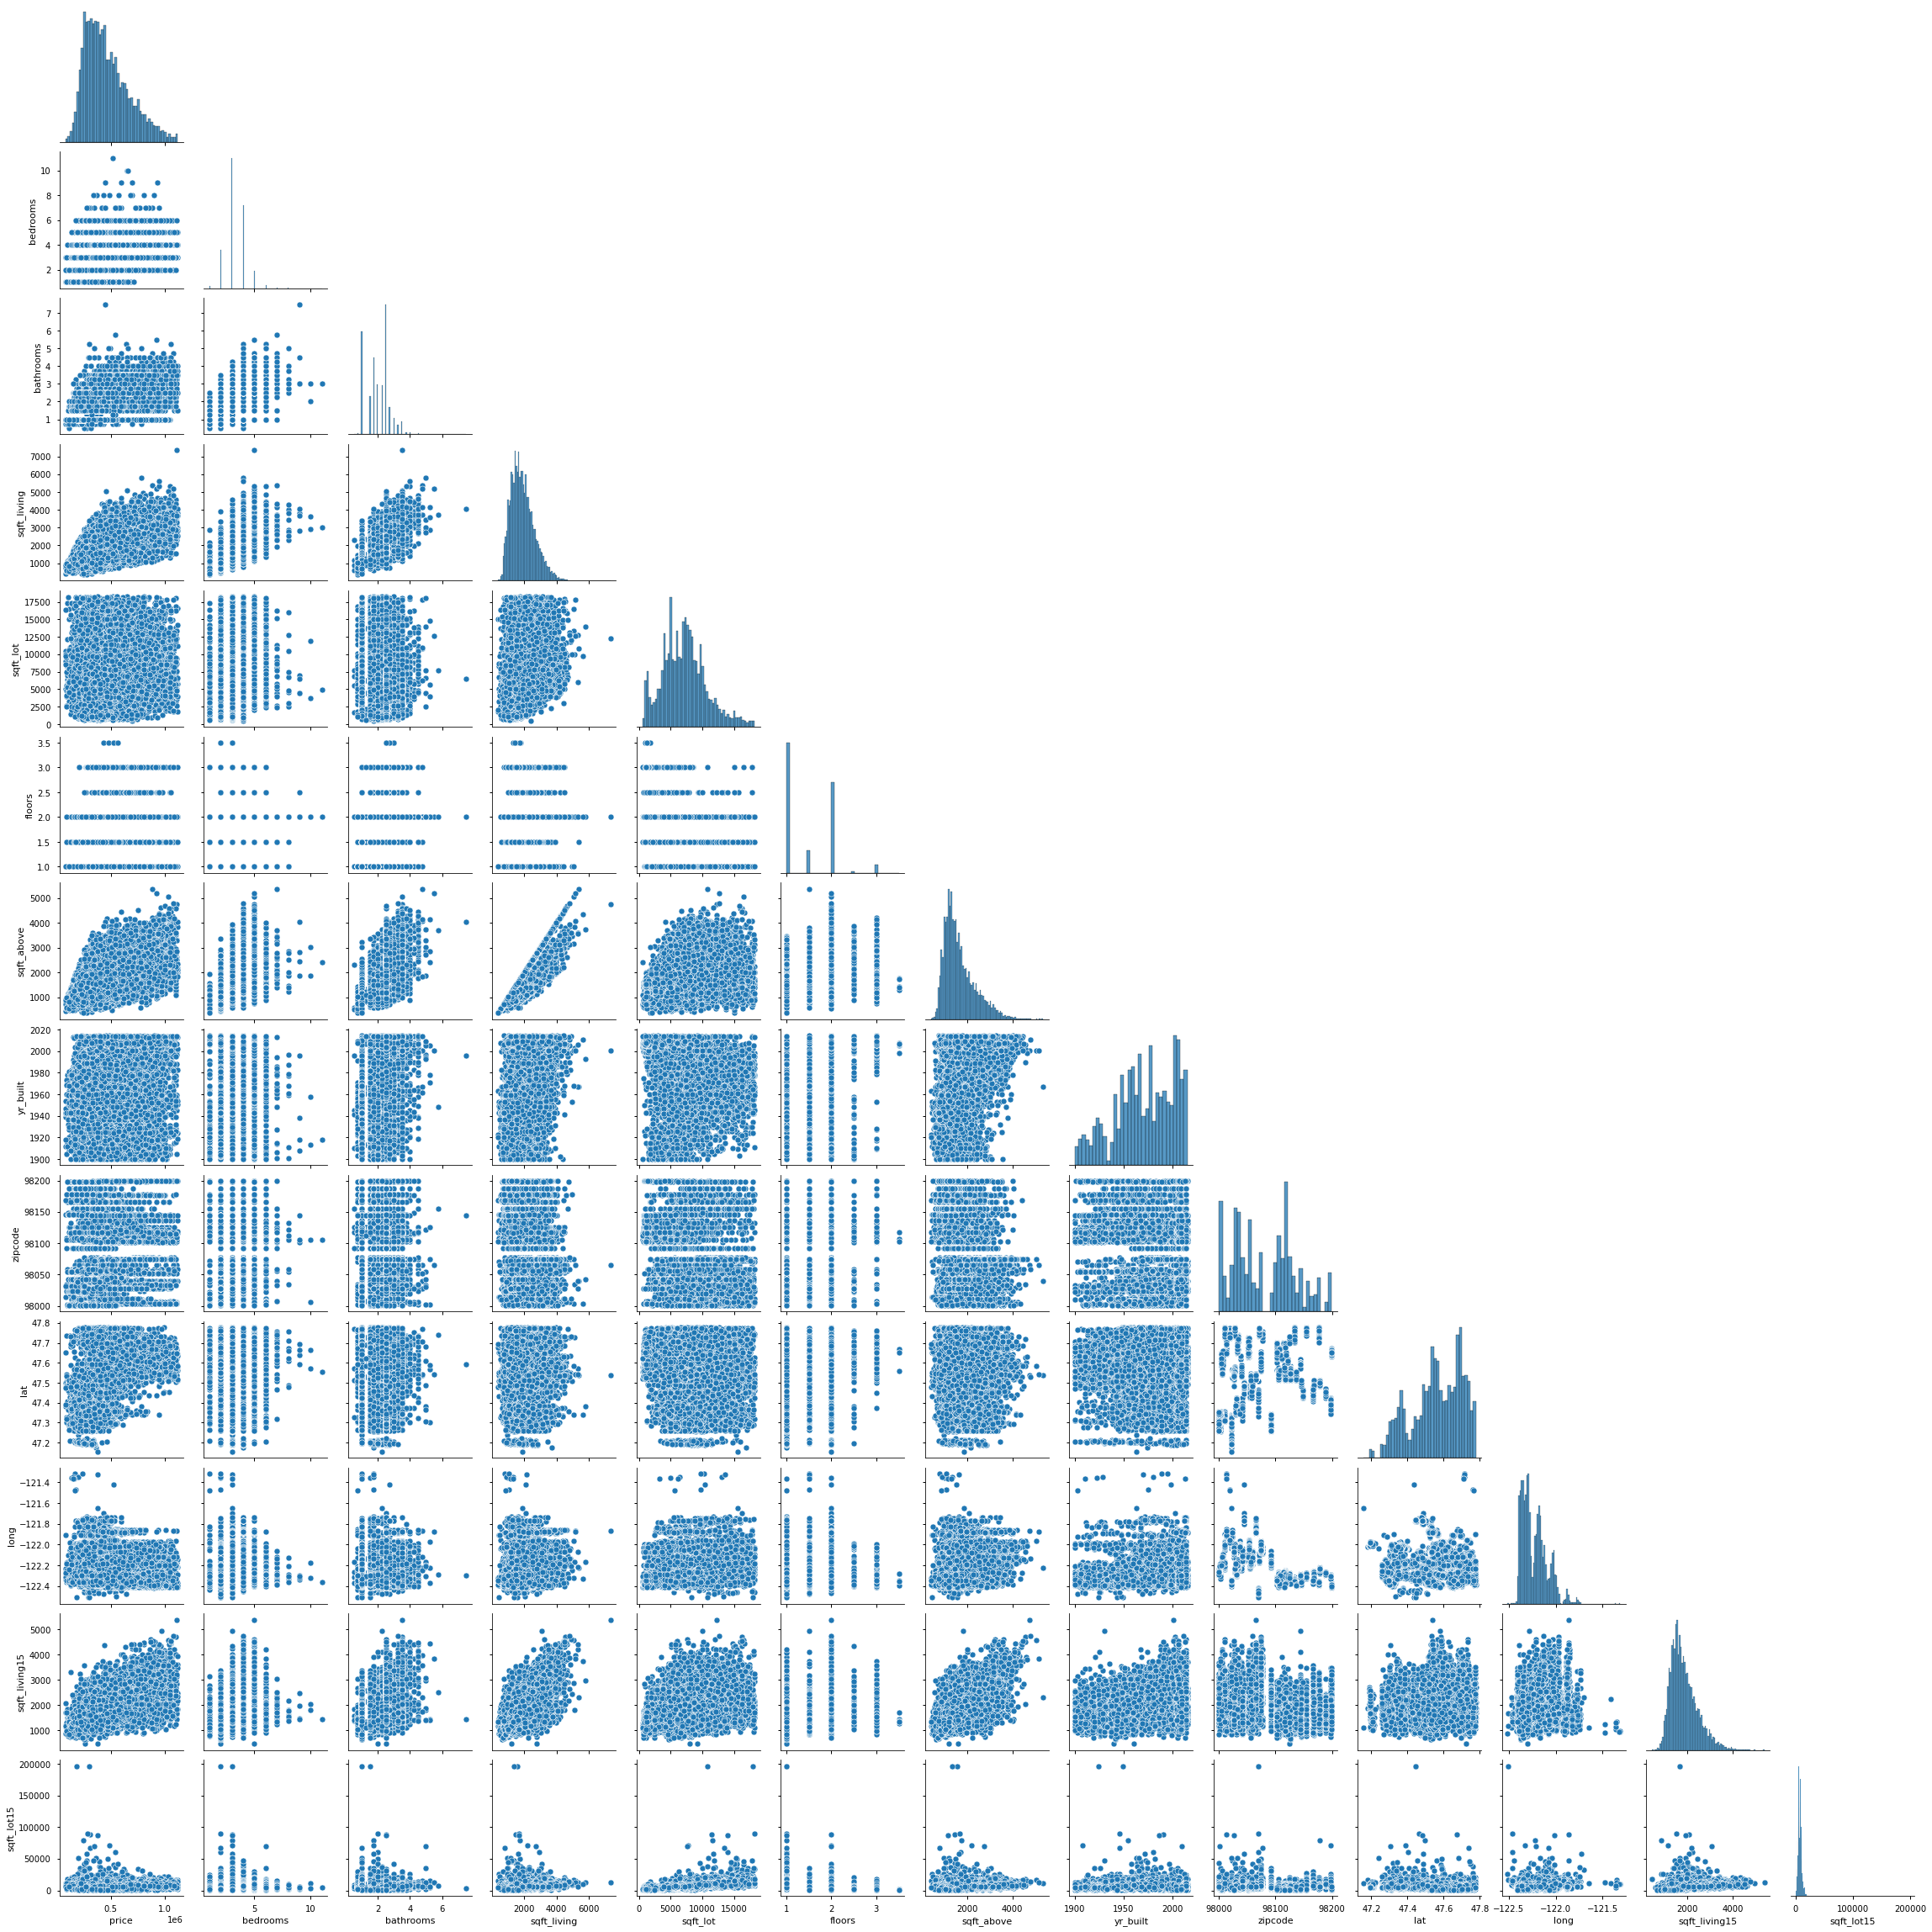

In [53]:
g = sns.pairplot(df, corner=True);
g

In [54]:
#Created a functions to get models, summaries, and encode data
def getmodel(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    mod = LinearRegression()
    mod.fit(X_train, y_train)
    pred = mod.predict(X_test)
 
    print(f'y intercept: {mod.intercept_}')
    print(f'slope: {mod.coef_}')
    print(f'R2: %.3f' %r2_score(y_test, pred))
    print(f'mean2 error: %.3f' %mean_squared_error(y_test, pred))
    print(f'predicted path: {pred}')
    
    Xrline = mod.coef_*X_test+mod.intercept_
    plt.scatter(y_test, pred, alpha=0.25);
    plt.plot(pred, Xrline);
    
    
    
    
def getols(x,y):
    
    x = sm.add_constant(x)
    result = sm.OLS(y, x).fit()
    print(result.summary())
    
    

    
def odinalencode(x):
    encode_x = OrdinalEncoder()

    encode_x.fit(x)

    x_encoded = encode_x.transform(x)
    x_encoded = x_encoded.flatten()
    return x_encoded

y intercept: 1.3390860747089834
slope: [1.47634333e-06]
R2: 0.184
mean2 error: 0.403
predicted path: [1.90585428 1.64616549 2.47587044 ... 1.83956646 2.33561783 2.01820401]


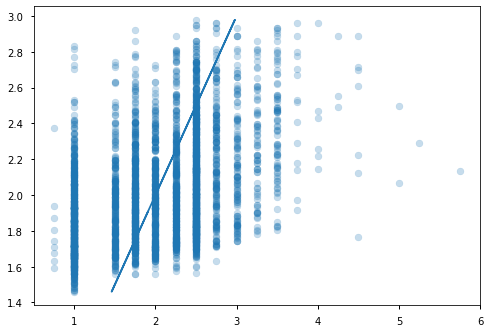

In [55]:
bathModel = getmodel(df[['price']], df['bathrooms'])

In [56]:
getols(df[['price']], df['bathrooms'])

                            OLS Regression Results                            
Dep. Variable:              bathrooms   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     4113.
Date:                Tue, 02 Aug 2022   Prob (F-statistic):               0.00
Time:                        22:42:11   Log-Likelihood:                -17614.
No. Observations:               18212   AIC:                         3.523e+04
Df Residuals:                   18210   BIC:                         3.525e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3361      0.012    113.506      0.0

y intercept: 913.2895587081598
slope: [0.00213771]
R2: 0.364
mean2 error: 324530.134
predicted path: [2518.71105007 1928.70261915 2628.80320294 ... 1543.91451204 1650.80009735
 2089.03099712]


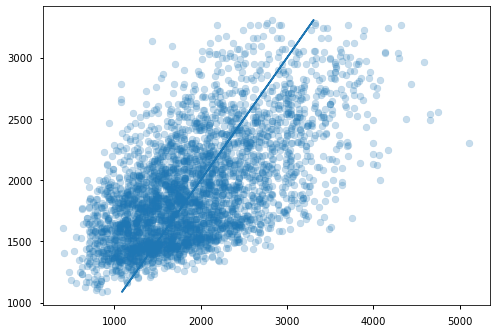

In [57]:

sqft_liv = getmodel(df[['price']], df['sqft_living'])
sqft_liv

In [58]:
    
getols(df[['price']], df['sqft_living'])

                            OLS Regression Results                            
Dep. Variable:            sqft_living   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                 1.019e+04
Date:                Tue, 02 Aug 2022   Prob (F-statistic):               0.00
Time:                        22:42:11   Log-Likelihood:            -1.4178e+05
No. Observations:               18212   AIC:                         2.836e+05
Df Residuals:                   18210   BIC:                         2.836e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        914.4278     10.761     84.972      0.0

y intercept: 1154.3215076965303
slope: [0.00152148]
R2: 0.292
mean2 error: 261228.293
predicted path: [1914.90944974 1800.95058425 1499.69750858 ... 2082.42441757 1877.02459325
 1603.15816083]


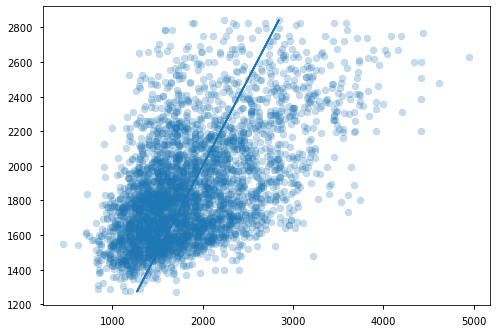

In [59]:
getmodel(df[['price']], df['sqft_living15'])

In [60]:
getols(df[['price']], df['sqft_living15'])

                            OLS Regression Results                            
Dep. Variable:          sqft_living15   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     7360.
Date:                Tue, 02 Aug 2022   Prob (F-statistic):               0.00
Time:                        22:42:11   Log-Likelihood:            -1.3879e+05
No. Observations:               18212   AIC:                         2.776e+05
Df Residuals:                   18210   BIC:                         2.776e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1148.4060      9.129    125.804      0.0

In [63]:
rndf = df.copy

In [64]:
#Revisitin DataFrame for reference
rndf = ndf[relcols]


r2 score: 0.39799212827482444


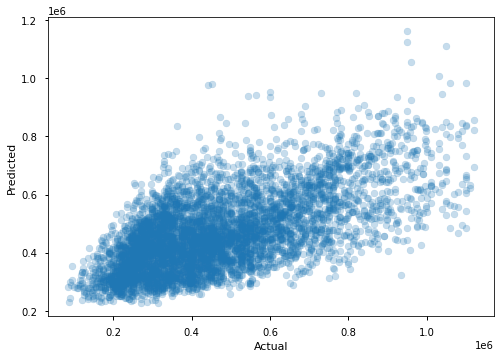

In [65]:
reg = LinearRegression()
X = rndf.drop(['price'],axis=1).values
y = rndf['price'].values

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

reg.fit(X_train,y_train)

pred = reg.predict(X_test)

print(f'r2 score: {r2_score(y_test, pred)}')

plt.scatter(y_test,pred,alpha=0.25);
plt.xlabel('Actual')
plt.ylabel('Predicted');

r2 score: 0.39799212827482444


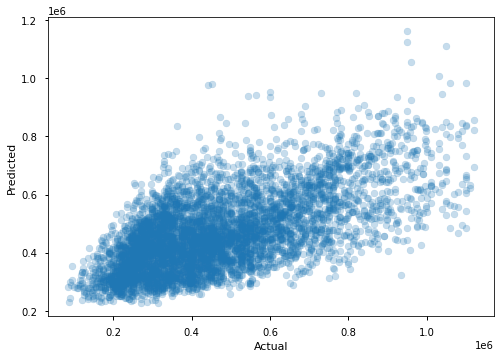

In [68]:
X = rndf.drop(['price'],axis=1).values
y = rndf['price'].values

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

reg.fit(X_train,y_train)

pred = reg.predict(X_test)

print(f'r2 score: {r2_score(y_test, pred)}')

plt.scatter(y_test,pred,alpha=0.25);
plt.xlabel('Actual')
plt.ylabel('Predicted');

In [145]:
df = pd.read_csv('./data/kc_house_data.csv', index_col=0, parse_dates=['date']) 

In [148]:

df.info()
#df.drop('date', axis=1, inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 7129300520 to 1523300157
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           21597 non-null  datetime64[ns]
 1   price          21597 non-null  float64       
 2   bedrooms       21597 non-null  int64         
 3   bathrooms      21597 non-null  float64       
 4   sqft_living    21597 non-null  int64         
 5   sqft_lot       21597 non-null  int64         
 6   floors         21597 non-null  float64       
 7   waterfront     21597 non-null  float64       
 8   view           21534 non-null  float64       
 9   condition      21597 non-null  int64         
 10  grade          21597 non-null  int64         
 11  sqft_above     21597 non-null  int64         
 12  sqft_basement  21597 non-null  float64       
 13  yr_built       21597 non-null  int64         
 14  yr_renovated   21597 non-null  float64       
 15  zipco

In [142]:
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,1.0,4,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,1.0,4,7,2170,0.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,1.0,4,4,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062
2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,1.0,6,7,1050,0.0,1965,0.0,98136,47.5208,-122.393,1360,5000
1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,1.0,4,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [70]:
df['waterfront'].value_counts().sum()

16163

In [147]:
df['waterfront'] = df['waterfront'].replace(np.nan, 'NO')
df['waterfront'] = odinalencode(df[['waterfront']])

viewdict = {'NONE':1,'AVERAGE':2,'GOOD':3,'FAIR':4,'EXCELLENT':5}
df['view'] = df['view'].map(viewdict)

condict = {'Poor':1,'Fair':2,'Fair':3,'Average':4,'Good':5,'Very Good':6}
df['condition'] = df['condition'].map(condict)

gradedict = {'3 Poor':1,'4 Low':2,'5 Fair':3,'6 Low Average':4,'7 Average':7,'8 Good':8,'9 Better':9,'10 Very Good':10,'11 Excellent':11,'12 Luxury':12,'13 Mansion':13}
df['grade'] = df['grade'].map(gradedict)

df['sqft_basement'] = df['sqft_basement'].map({'?':0})
df['sqft_basement'] = df['sqft_basement'].replace(np.nan, 0)

df['yr_renovated'] = df['yr_renovated'].replace(np.nan, 0)

In [149]:
#df.drop('waterfront',axis=1,inplace=True)
#df.drop('yr_renovated',axis=1,inplace=True)
#df.drop('sqft_basement',axis=1,inplace=True)
#df.drop('grade',axis=1,inplace=True)
df.drop('view',axis=1,inplace=True)
df.drop('date',axis=1,inplace=True)

In [150]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,
7129300520,221900.0,3,1.00,1180,5650,1.0,0.0,4,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
6414100192,538000.0,3,2.25,2570,7242,2.0,0.0,4,7,2170,0.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
5631500400,180000.0,2,1.00,770,10000,1.0,0.0,4,4,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062
2487200875,604000.0,4,3.00,1960,5000,1.0,0.0,6,7,1050,0.0,1965,0.0,98136,47.5208,-122.393,1360,5000
1954400510,510000.0,3,2.00,1680,8080,1.0,0.0,4,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [74]:
df['view'].value_counts()

NONE         16870
AVERAGE        681
GOOD           257
FAIR           246
EXCELLENT      104
Name: view, dtype: int64

In [76]:
df['condition'].value_counts()

Average      11900
Good          4726
Very Good     1433
Fair           132
Poor            21
Name: condition, dtype: int64

In [78]:
df['grade'].value_counts()

7 Average        8371
8 Good           5297
6 Low Average    1872
9 Better         1866
10 Very Good      513
5 Fair            198
11 Excellent       75
4 Low              20
Name: grade, dtype: int64

In [82]:
df['sqft_basement'].value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
1008.0        1
508.0         1
143.0         1
915.0         1
2250.0        1
Name: sqft_basement, Length: 304, dtype: int64

In [91]:
df['zipcode'].value_counts()

98103    602
98038    589
98115    583
98052    574
98117    553
        ... 
98102    104
98010    100
98024     80
98148     57
98039     50
Name: zipcode, Length: 70, dtype: int64

r2 score: 0.6811253034172384


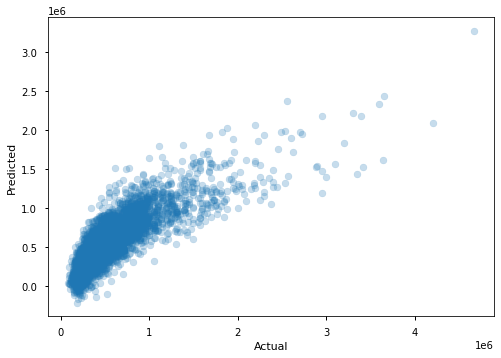

In [151]:
X = df.drop(['price'],axis=1).values
y = df['price'].values

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

reg.fit(X_train,y_train)

pred = reg.predict(X_test)

print(f'r2 score: {r2_score(y_test, pred)}')

plt.scatter(y_test,pred,alpha=0.25);
plt.xlabel('Actual')
plt.ylabel('Predicted');

In [174]:
a = np.array(df['bedrooms'])
a.std()

0.9262774492113767

In [175]:
def std3(x):
    y = x.mean() + 3 * x.std()
    return y
    
    
    
a = std3(a)
#4834.576458532849

a

6.152032329113039

# Visualization

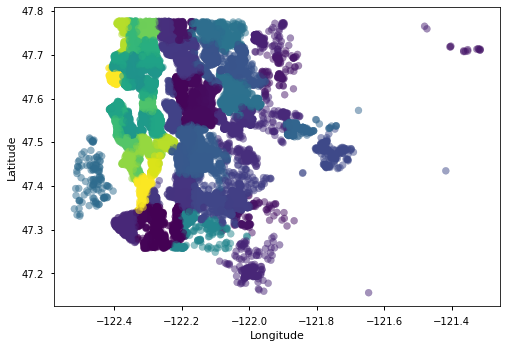

In [180]:
colors = df['zipcode']

lon = df['long']
lat = df['lat']
plt.scatter(lon,lat,c=colors,alpha=0.5);
plt.xlabel('Longitude');
plt.ylabel('Latitude');